In [1]:
import gym
import random
import time
import numpy as np
import pandas as pd
from IPython.display import clear_output

from gym.envs.registration import register


# wrap in a try block to supress a warning we don't care about
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

## Intro to Q learning

#### Overview:

Before we created a random agent that can simulate continuous and discrete action spaces. Now we'll be looking at Frozen Lake. Slippery ice means actions don't always pan out (stochastic). We'll set `is_slippery` to `False` to make this a deterministic environment.

Change iteration loop to run while `done=False`.

Print updates at 0.5 second intervals.

Flush notebook output with `clear_output` command.

https://www.youtube.com/watch?v=wN3rxIKmMgE&list=PLIfPjWrv526bMF8_vx9BqWjec-F-g-lQO&index=3

In [2]:
#env_name = "CartPole-v1"
#env_name = "MountainCar-v0"
#env_name = "MountainCarContinuous-v0"
#env_name = "Acrobot-v1"
#env_name = "Pendulum-v0"
#env_name = "FrozenLake-v0"
env_name = "FrozenLakeNoSlip-v0"   # we set is_slippery=False in the register up above

env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

type(env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


gym.spaces.discrete.Discrete

In [3]:
class Agent():
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Action size:", self.action_size)
            
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("Action range:", self.action_low, self.action_high)
        
    def get_action(self, state):
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                      self.action_high,
                                      self.action_shape)
        return action

To implement Q-learning, create Q-agent which a subclass of the parent agent.

Q table:
-States as rows
-Actions as columns

#### Redfine get-action method to select actions corresponding to the state. `argmax` is used to select the action with highest q-value.

#### Define a `train` method for updating the q-table at each step.

- It receives the `experience` tuple with `(state, action, next_state, reward, done)`.
- Calls for `q_next` (pulls next_state from q-table), and checks if this next_state is `done`.
- Calculates `q_target` from the Q-learning equation (reward plus _discounted_ future reward)
- Calculates `q_update`, which is the distance from the current q-value to the target.
- Pushes update to the q-table using _learning rate_.
- Constructor defines both the `discount_rate` and the `learning_rate` used above.

#### Balance exploration vs exploitation (aka policy or greedy action): epsilon (eps)
Start with high epsilon (aka 1.0 to explore 100% of the time), then exponentially decay eps at each terminal step

In [4]:
# QAgent is a subclass of the Agent class above

class QAgent(Agent):
    def __init__(self, env, discount_rate, learning_rate):
        super().__init__(env)
        
        # Action size already defined above in parent class
        
        # Define and printout state size here:
        self.state_size = env.observation_space.n
        print("State size", self.state_size)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        # build a Q table
        self.build_model()
        
    def build_model(self):
        np.random.seed(17)
        self.q_table = 1e-4*np.random.random([self.state_size, self.action_size])
        
    # modify get_action method
    def get_action(self, state):
        q_state = self.q_table[state]
        
        # exploration vs exploitation using probability of epsilon
        action_greedy = np.argmax(q_state)
        action_random = super().get_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience):
        state, action, next_state, reward, done = experience
        
        # q table
        q_next = self.q_table[next_state]
        q_next = np.zeros([self.action_size]) if done else q_next
        q_target = reward + self.discount_rate * np.max(q_next)
        
        q_update = q_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * q_update
        
        # Exponential decay of epsilon when reaching a terminal step
        if done:
            self.eps = self.eps * 0.99
        


### Adjusting the simulation loop for training

- env.step returns the next step, so make a variable called next_step
- call train method
- update the state to the next state
- train over a number of episodes
- and track the reward

In [5]:
def run(discount_rate, learning_rate):    
    agent = QAgent(env, discount_rate, learning_rate)
    total_reward = 0
    
    total_rewards = []
    for ep in range(100):
        state = env.reset()
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train((state,action,next_state,reward,done))
            state = next_state
            total_reward += reward

            print("s:", state, "a:", action)
            print("Episode: {}, Total Reward: {}, eps: {}".format(ep,total_reward,agent.eps))
            env.render()
            print(agent.q_table)
            time.sleep(0.5)
            clear_output(wait=True)
            
        total_rewards.append(total_reward)
    return total_rewards
        
            

In [6]:
run1 = run(0.97, 0.01)

s: 5 a: 3
Episode: 99, Total Reward: 8.0, eps: 0.36603234127322926
  (Up)
SFFF
FHFH
FFFH
HFFG
[[3.67322375e-05 5.56035322e-05 3.74315378e-05 1.98063435e-05]
 [7.23214272e-05 5.81764105e-05 6.43088753e-05 5.93010445e-05]
 [4.62280850e-06 3.58294767e-05 9.44736073e-05 6.00446803e-06]
 [8.64565622e-05 8.77290526e-05 5.11936656e-06 6.52418615e-05]
 [5.56362081e-05 5.84326451e-05 3.54089641e-05 3.48804622e-05]
 [2.97725718e-05 5.61508905e-05 3.96047436e-05 7.88700710e-05]
 [4.14299541e-05 1.43903921e-05 1.50906694e-05 5.52413502e-06]
 [7.18037194e-05 2.92317355e-05 1.98773872e-05 8.31363922e-05]
 [5.64029648e-05 6.73462521e-06 6.27164268e-05 2.47043589e-05]
 [6.68272870e-05 5.29317702e-05 4.69588492e-05 7.04715543e-05]
 [7.97267730e-05 3.93496877e-04 9.41668080e-05 6.59205392e-05]
 [7.18776083e-05 7.43576765e-05 8.87736352e-05 1.33945668e-05]
 [7.76974581e-05 8.37991512e-05 8.29304764e-05 2.91569965e-06]
 [3.78779979e-05 5.49752786e-05 2.38638590e-03 5.00033826e-05]
 [1.49118193e-05 1.31727

In [7]:
run2 = run(0.97, 0.1)

s: 15 a: 2
Episode: 99, Total Reward: 25.0, eps: 0.36603234127322926
  (Right)
SFFF
FHFH
FFFH
HFFG
[[1.99551504e-02 5.43965263e-04 7.24364384e-02 6.48038838e-03]
 [7.36876217e-05 4.24062463e-06 1.57300843e-01 1.96981426e-02]
 [6.04631459e-04 3.17721831e-01 9.35311076e-03 8.20225607e-03]
 [5.58391607e-02 1.46307335e-05 3.21193419e-04 7.29556181e-05]
 [5.56263478e-05 5.98383735e-05 3.17243130e-05 8.61795842e-03]
 [2.97725718e-05 5.61508905e-05 3.96047436e-05 7.88700710e-05]
 [2.22399760e-05 5.43566939e-01 8.91088940e-06 5.45512068e-02]
 [7.18037194e-05 2.92317355e-05 1.98773872e-05 8.31363922e-05]
 [5.70693474e-05 4.86207985e-06 4.07924777e-03 2.37479347e-05]
 [6.41268062e-05 2.31228239e-05 2.45161614e-01 5.82605275e-05]
 [2.88863072e-02 7.73788091e-01 4.59541805e-05 1.01777146e-01]
 [7.18776083e-05 7.43576765e-05 8.87736352e-05 1.33945668e-05]
 [7.76974581e-05 8.37991512e-05 8.29304764e-05 2.91569965e-06]
 [3.51337042e-05 1.12690372e-02 1.78993430e-01 2.03940085e-02]
 [5.00938274e-02 2.

In [8]:
run3 = run(0.97, 1.0)

s: 15 a: 2
Episode: 99, Total Reward: 24.0, eps: 0.36603234127322926
  (Right)
SFFF
FHFH
FFFH
HFFG
[[8.32972005e-01 8.58734026e-01 8.58734026e-01 8.32972005e-01]
 [8.32972005e-01 0.00000000e+00 8.85292810e-01 7.95365006e-05]
 [7.95365006e-05 9.12673000e-01 8.00309304e-05 8.85292810e-01]
 [8.85292810e-01 0.00000000e+00 7.53359225e-05 8.00309304e-05]
 [8.58734026e-01 8.85292810e-01 0.00000000e+00 8.32972005e-01]
 [2.97725718e-05 5.61508905e-05 3.96047436e-05 7.88700710e-05]
 [0.00000000e+00 9.40900000e-01 0.00000000e+00 8.85292810e-01]
 [7.18037194e-05 2.92317355e-05 1.98773872e-05 8.31363922e-05]
 [8.85292810e-01 0.00000000e+00 9.12673000e-01 8.58734026e-01]
 [8.85292810e-01 9.40900000e-01 9.40900000e-01 0.00000000e+00]
 [9.12673000e-01 9.70000000e-01 0.00000000e+00 9.12673000e-01]
 [7.18776083e-05 7.43576765e-05 8.87736352e-05 1.33945668e-05]
 [7.76974581e-05 8.37991512e-05 8.29304764e-05 2.91569965e-06]
 [0.00000000e+00 9.40900000e-01 9.70000000e-01 9.12673000e-01]
 [9.40900000e-01 9.

In [9]:
run4 = run(0.97, 3.0)

s: 7 a: 1
Episode: 99, Total Reward: 3.0, eps: 0.36603234127322926
  (Down)
SFFF
FHFH
FFFH
HFFG
[[ 1.06388171e+96  3.51647078e+94  3.54714107e+95  7.07474208e+95]
 [ 7.83819495e+90 -1.40946551e+05  9.31964000e+94  8.38341784e+92]
 [-1.32734763e+95  5.89819135e+46  6.43824169e+43  8.13186028e+62]
 [ 3.43366585e+42  5.61465937e-03  4.69874803e+42  1.24807820e-04]
 [ 3.32862765e+88  7.34245032e+94  8.30695851e+05 -2.76711895e+87]
 [ 2.97725718e-05  5.61508905e-05  3.96047436e-05  7.88700710e-05]
 [ 6.69575017e-04  2.50808453e-04  6.03626778e-05 -8.58473858e+63]
 [ 7.18037194e-05  2.92317355e-05  1.98773872e-05  8.31363922e-05]
 [ 1.69219543e+94  2.15848712e+00  4.65634425e+49 -3.52734388e+94]
 [ 6.76762386e-05  1.08083682e+04  2.29726984e+62 -1.77596487e-04]
 [ 2.63223765e+49  7.00647481e+02 -1.92157551e-04  1.57759770e+64]
 [ 7.18776083e-05  7.43576765e-05  8.87736352e-05  1.33945668e-05]
 [ 7.76974581e-05  8.37991512e-05  8.29304764e-05  2.91569965e-06]
 [ 3.90374491e-05  4.37251992e-05

In [10]:
run1[-1]

8.0

In [11]:
run2[-1]

25.0

In [12]:
run3[-1]

24.0

In [13]:
run4[-1]

3.0

In [14]:
from matplotlib import pyplot as plt

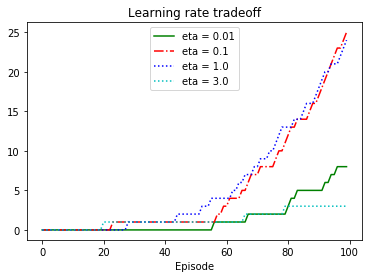

In [17]:
episodes = [ep for ep in range(100)]

plt.plot(episodes, run1, 'g-', label='eta = 0.01')   # green solid line
plt.plot(episodes, run2, 'r-.', label='eta = 0.1') # red dot-dashed line
plt.plot(episodes, run3, 'b:', label='eta = 1.0') # blue dotted line
plt.plot(episodes, run4, 'c:', label='eta = 3.0') # blue dotted line


plt.legend(loc=9) # loc=9 means "top center"
plt.xlabel("Episode")
plt.title("Learning rate tradeoff")
plt.show()